# New Section

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
import csv
import time

# Define paths to the dataset directories
train_dir = '/content/drive/MyDrive/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_training'
dev_dir = '/content/drive/MyDrive/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_development'
test_dir = '/content/drive/MyDrive/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_evaluation'

# Load the datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  # Adjust based on your model's input size
    batch_size=32,
    label_mode='categorical'  # Use 'categorical' for binary classification with softmax
)

dev_dataset = image_dataset_from_directory(
    dev_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)


def write_into_csv(model_params):
    #add extra info into end of model info in csv file
    x = 0
    with open(csv_file, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)

        # Write top-level key-value pairs
        for key, value in model_params.items():
            if x == 0:
              writer.writerow([key, value])
              x+=1
            elif not isinstance(value, dict):  # Check if value is not a dictionary
                writer.writerow([key, value])
            else:  # Handle nested dictionary (data_augmentation)
                for inner_key, inner_value in value.items():
                    writer.writerow([key + '/' + inner_key, inner_value])


model_number = int(input("enter your last model number: "))
csv_file = 'output.csv'
model_params = {
    "epochs": 7,
    "callbacks": {
        "EarlyStopping": {"monitor": "val_loss", "patience": 2},
        "ModelCheckpoint": {"filepath": "model_checkpoint.keras", "save_best_only": True, "monitor": "val_loss", "verbose": 1},
        "CSVLogger":{"filename":csv_file,"separator":",","append":"True"}
    }
}

callbacks = [
    tf.keras.callbacks.EarlyStopping(**model_params['callbacks']['EarlyStopping']),
    tf.keras.callbacks.ModelCheckpoint(**model_params['callbacks']['ModelCheckpoint']),
    # tf.keras.callbacks.ReduceLROnPlateau(**model_params['callbacks']['ReduceLROnPlateau']),
    # tf.keras.callbacks.LearningRateScheduler(**model_params['callbacks']['LearningRateScheduler']),
    tf.keras.callbacks.CSVLogger(**model_params['callbacks']['CSVLogger']),
    # tf.keras.callbacks.TerminateOnNaN()
]
write_into_csv({' ':' ','model number':model_number})


Found 8299 files belonging to 2 classes.
Found 2948 files belonging to 2 classes.
Found 7580 files belonging to 2 classes.
enter your last model number: 2


In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load a pre-trained model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# Specify the number of layers to unfreeze from the end
num_layers_to_unfreeze = 10

# Unfreeze the last `num_layers_to_unfreeze` layers
for layer in base_model.layers[-num_layers_to_unfreeze:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(2, activation='softmax')(x)  # Binary classification with softmax

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

94765736/94765736 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [4]:
start_time = time.time()
# Train the model
history = model.fit(
    train_dataset,
    epochs=model_params['epochs'],
    validation_data=dev_dataset,
    callbacks=callbacks,
    # verbose = 1,
    shuffle = True,


)
end_time = time.time()
elapsed_time = end_time - start_time


Epoch 1/7
260/260 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.9482
Epoch 1: val_loss improved from inf to 0.27036, saving model to model_checkpoint.keras
260/260 [==============================] - 1689s 6s/step - loss: 0.1615 - accuracy: 0.9482 - val_loss: 0.2704 - val_accuracy: 0.9081
Epoch 2/7
260/260 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9819
Epoch 2: val_loss improved from 0.27036 to 0.25831, saving model to model_checkpoint.keras
260/260 [==============================] - 150s 567ms/step - loss: 0.0517 - accuracy: 0.9819 - val_loss: 0.2583 - val_accuracy: 0.9332
Epoch 3/7
259/260 [============================>.] - ETA: 0s - loss: 0.0280 - accuracy: 0.9900
Epoch 3: val_loss improved from 0.25831 to 0.25281, saving model to model_checkpoint.keras
260/260 [==============================] - 146s 551ms/step - loss: 0.0282 - accuracy: 0.9899 - val_loss: 0.2528 - val_accuracy: 0.9437
Epoch 4/7
259/260 [========================

In [5]:
model.save_weights('/content/drive/MyDrive/deep_learning_1.h5')

best Test accuracy: 0.9436906576156616 ,best test loss :0.25280678272247314 


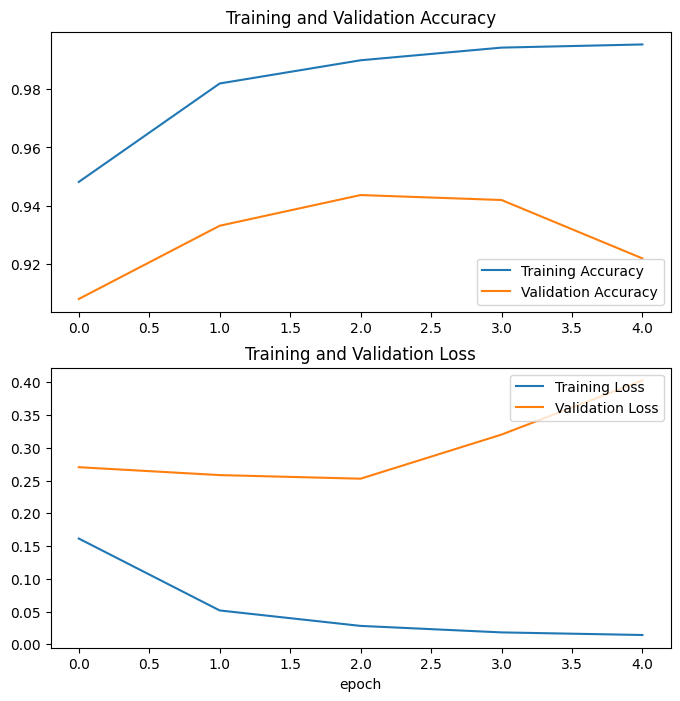

KeyboardInterrupt: 

In [6]:
import matplotlib.pyplot as plt
best_val_acc = max(history.history['val_accuracy'])
best_val_loss=min(history.history['val_loss'])
print(f"best Test accuracy: {best_val_acc} ,best test loss :{best_val_loss} ")
write_into_csv({"best test accuracy":best_val_acc,"best test loss":best_val_loss,"elapsed time":elapsed_time})
write_into_csv(model_params)
for layer in model.layers:
  layer_info = {
  f"Layer Type":f" {type(layer).__name__}",
  f"Output Shape":f" {layer.output_shape}",
  f"Number of Parameters":f"{layer.count_params()}",
  }
  write_into_csv(layer_info)


# Plot the training and validation loss and accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(f'plot_{model_number}.png')
plt.show()

# Evaluate the model on the test dataset
# test_loss, test_acc = model.evaluate(test_dataset)
# print(f'Test accuracy: {test_acc}')

In [7]:
from google.colab import files


# Download the CSV file
files.download(csv_file)

# Download the image file
files.download(f'plot_{model_number}.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
# model = load_model('path/to/best_model.h5')

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Define the target size
target_size = (224, 224)  # Replace with your model's input size

# Preprocess the image
# img_path = '/content/3.jpg'
# img_path = '/content/4.jpg'
# img_path = '/content/5.jpg'
# img_path = '/content/6.jpg'
# img_path = '/content/drive/MyDrive/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_training/real/AA5742_id154_s0_112.png'
# img_path = '/content/drive/MyDrive/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_training/spoof/FT720P_G780_REDMI4X_id1_s0_105.png'
# img_path = '/content/drive/MyDrive/kaggle/input/lcc-fasd/LCC_FASD/LCC_FASD_training/spoof/FT720P_G780_REDMI4X_id1_s0_30.png'
preprocessed_image = preprocess_image(img_path, target_size)

# Make a prediction
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions, axis=1)

# Example class labels (replace with your actual labels)
class_labels = [';', 'class2']
predicted_label = class_labels[predicted_class[0]]
print(predicted_class)
print(f'Predicted label: {predicted_label}')

1/1 [==============================] - 0s 34ms/step
[0]
Predicted label: ;
